In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [3]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [4]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]


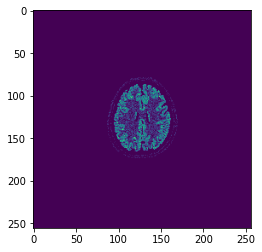

In [5]:
plt.imshow(img_noisyDataSet1[19,0,:,:])

In [6]:
# Error cuadratico medio entre dos imagenes

def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
        error = suma / cantPix
        return error

In [7]:
MSE_dataSet1_slice100 = MSE(img_noisyDataSet1[5,0,:,:],img_groundTruth[5,0,:,:])
print(MSE_dataSet1_slice100)

0.35028509543889563


In [8]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.layer1Down = nn.Sequential (
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
        self.layer2Down = nn.Sequential (
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size= 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer3Down = nn.Sequential (
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer4Down = nn.Sequential (
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer5Down = nn.Sequential (
            torch.nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        self.Pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Expand
        
        self.layer5ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer4Up = nn.Sequential (
            torch.nn.Conv2d(512, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer4ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer3Up = nn.Sequential (
            torch.nn.Conv2d(256, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer3ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer2Up = nn.Sequential (
            torch.nn.Conv2d(128, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer2ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer1Up = nn.Sequential (
            torch.nn.Conv2d(64, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
    
    def forward(self, x):

        # Down
        conv1 = self.layer1Down(x)
        maxPool1 = self.Pooling(conv1)
        
        
        conv2 = self.layer2Down(maxPool1)
        maxPool2 = self.Pooling(conv2)
        
        conv3 = self.layer3Down(maxPool2)
        maxPool3 = self.Pooling(conv3)
        
        conv4 = self.layer4Down(maxPool3)
        maxPool4 = self.Pooling(conv4)
        
        conv5 = self.layer5Down(maxPool4)
        
        # Up
        layerConvTransposed = self.layer5ConvTransposed(conv5)
        layer4UpData = torch.cat((layerConvTransposed,conv4), dim=1)
        convTrans4 = self.layer4Up(layer4UpData)
        
 
        layerConvTransposed = self.layer4ConvTransposed(convTrans4)
        layer3UpData = torch.cat((layerConvTransposed,conv3), dim = 1)
        convTrans3 = self.layer3Up(layer3UpData)
        
        layerConvTransposed = self.layer3ConvTransposed(convTrans3)
        layer2UpData = torch.cat((layerConvTransposed,conv2), dim = 1)
        convTrans2 = self.layer2Up(layer2UpData)
        
        layerConvTransposed = self.layer2ConvTransposed(convTrans2)
        layer1UpData = torch.cat((layerConvTransposed,conv1), dim = 1)
        convTrans1 = self.layer1Up(layer1UpData)
        
        outNet = torch.nn.Conv2d(32,1, kernel_size = 1)(convTrans1)
        return outNet

unet = Unet()
        

In [9]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]



In [11]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.expand_dims(gT, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')


img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

MSE orig 0.3502850830554962
MSE test 3.8332042694091797


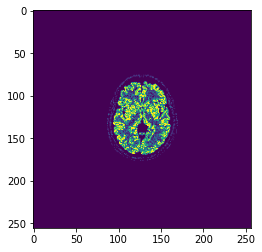

In [12]:
scaleForVisualization = 1.2*gT_np.max()

plt.imshow(inputs_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

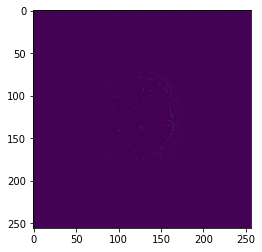

In [13]:
plt.imshow(out_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [14]:

# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.expand_dims(vinputs, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.expand_dims(validGroundTruth, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:
  image 10 loss: 3.079953896999359
LOSS train 3.079953896999359 valid 2.2926077842712402
EPOCH 2:


c:\users\ecyt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\module.py:1384: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  " and ".join(warn_msg) + " are deprecated. nn.Module.state_dict will not accept them in the future. "


  image 10 loss: 2.357658624649048
LOSS train 2.357658624649048 valid 2.0580434799194336
EPOCH 3:
  image 10 loss: 2.3322875618934633
LOSS train 2.3322875618934633 valid 2.5858471393585205
EPOCH 4:
  image 10 loss: 2.203083837032318
LOSS train 2.203083837032318 valid 2.0923523902893066
EPOCH 5:
  image 10 loss: 3.0175473213195803
LOSS train 3.0175473213195803 valid 2.2987475395202637
EPOCH 6:
  image 10 loss: 2.9340421080589296
LOSS train 2.9340421080589296 valid 2.372476100921631
EPOCH 7:
  image 10 loss: 2.7322509407997133
LOSS train 2.7322509407997133 valid 2.263906955718994
EPOCH 8:
  image 10 loss: 2.165176570415497
LOSS train 2.165176570415497 valid 1.8556785583496094
EPOCH 9:
  image 10 loss: 2.258222734928131
LOSS train 2.258222734928131 valid 2.443645477294922
EPOCH 10:
  image 10 loss: 2.652447509765625
LOSS train 2.652447509765625 valid 3.1430273056030273
EPOCH 11:
  image 10 loss: 2.454836845397949
LOSS train 2.454836845397949 valid 2.0100390911102295
EPOCH 12:
  image 10 l

In [16]:
# CONJUNTO DE ENTRENAMIENTO

if __name__ == '__main__':
    inputsTrain = train_noisyImage[5]
    inputsTrain = np.expand_dims(inputsTrain, axis=-3)
    inputsTrain = torch.Tensor(inputsTrain)
    model = Unet()
    outTrain = unet(inputsTrain)
    
gTtrain = train_groundTruth[5]
gTtrain = np.expand_dims(gTtrain, axis=-3)
gTtrain = torch.Tensor(gTtrain)


inputsTrain_np = inputsTrain.detach().numpy()
outTrain_np = outTrain.detach().numpy()
gTtrain_np = gTtrain.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])
MSE_test = MSE(outTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii
img_inputs = sitk.GetImageFromArray(inputsTrain_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTrain.nii')

img_out = sitk.GetImageFromArray(outTrain_np[0,0,:,:])
sitk.WriteImage(img_out,'outTrain.nii')

img_gTtest = sitk.GetImageFromArray(gTtrain_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthTrain.nii')



MSE orig 0.3234834671020508
MSE test 2.2979540824890137


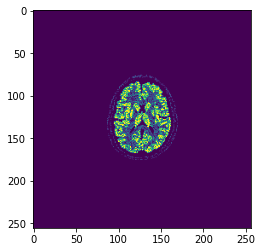

In [17]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

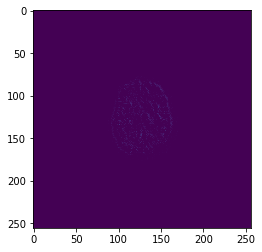

In [19]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

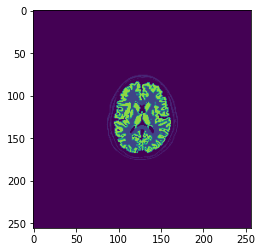

In [28]:
plt.imshow(gTtrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [25]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.expand_dims(inputsTest, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    model = Unet()
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims(gTtest, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputsTest_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTest.nii')

img_out = sitk.GetImageFromArray(outTest_np[0,0,:,:])
sitk.WriteImage(img_out,'outTest.nii')

img_gTtest = sitk.GetImageFromArray(gTtest_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtest.nii')

MSE orig 0.2929879426956177
MSE test 1.9825598001480103


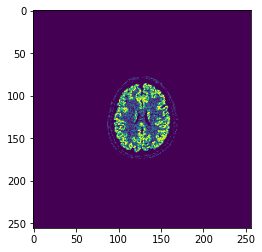

In [26]:
plt.imshow(inputsTest_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

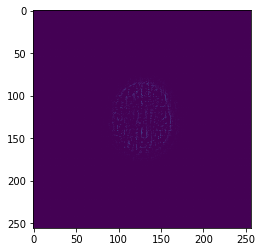

In [27]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )